In [1]:
from config import  AE_HF_NAME, MODELS_DIR_BASE
import torch
from diffusers import AutoencoderDC
from config import AE_HF_NAME, MODELS_DIR_BASE
import torch
from IPython.display import display
from torchvision.transforms.v2 import ToPILImage
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xformers\__init__.py", line 57, in _is_triton_available
    import triton  # noqa
    ^^^^^^^^^^^^^
ModuleNotFoundError: No module named 'triton'


In [2]:
DTYPE= torch.bfloat16
device = torch.device("cuda:0")

In [3]:
ae = AutoencoderDC.from_pretrained(f"mit-han-lab/{AE_HF_NAME}", torch_dtype=DTYPE, cache_dir=f"{MODELS_DIR_BASE}/dc_ae", revision="main").to(device).eval()

In [4]:
# load tesla.jpg
img = Image.open("tesla.jpg")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(), 
])

tensor_img = transform(img).unsqueeze(0)

print(f"Tensor shape: {tensor_img.shape}")


Tensor shape: torch.Size([1, 3, 1216, 1728])


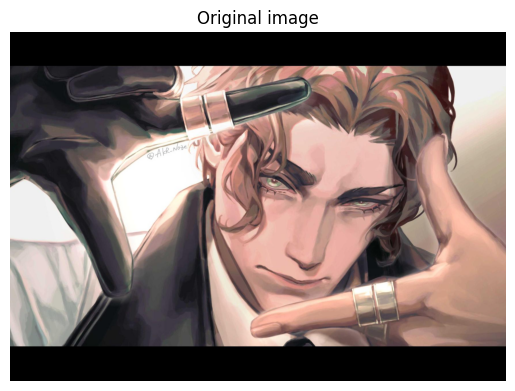

In [38]:
image = tensor_img.cpu().detach().to(torch.float32).squeeze().numpy().transpose(1,2,0)

plt.imshow(image)
plt.axis("off")
plt.title("Original image")
plt.show()

In [39]:
with torch.no_grad():
    tensor_img = tensor_img.to(device, DTYPE)

    latents = ae.encode(tensor_img).latent

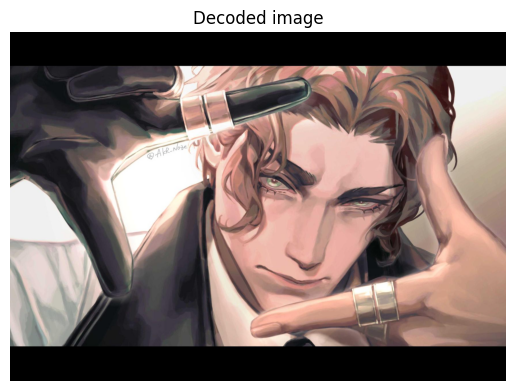

In [40]:
with torch.no_grad():
    decoded = ae.decode(latents).sample

    image = tensor_img.cpu().to(torch.float32).squeeze().numpy().transpose(1,2,0)

    plt.imshow(image)
    plt.axis("off")
    plt.title("Decoded image")
    plt.show()

In [29]:
latents = latents.to(torch.float32).to("cpu").squeeze()

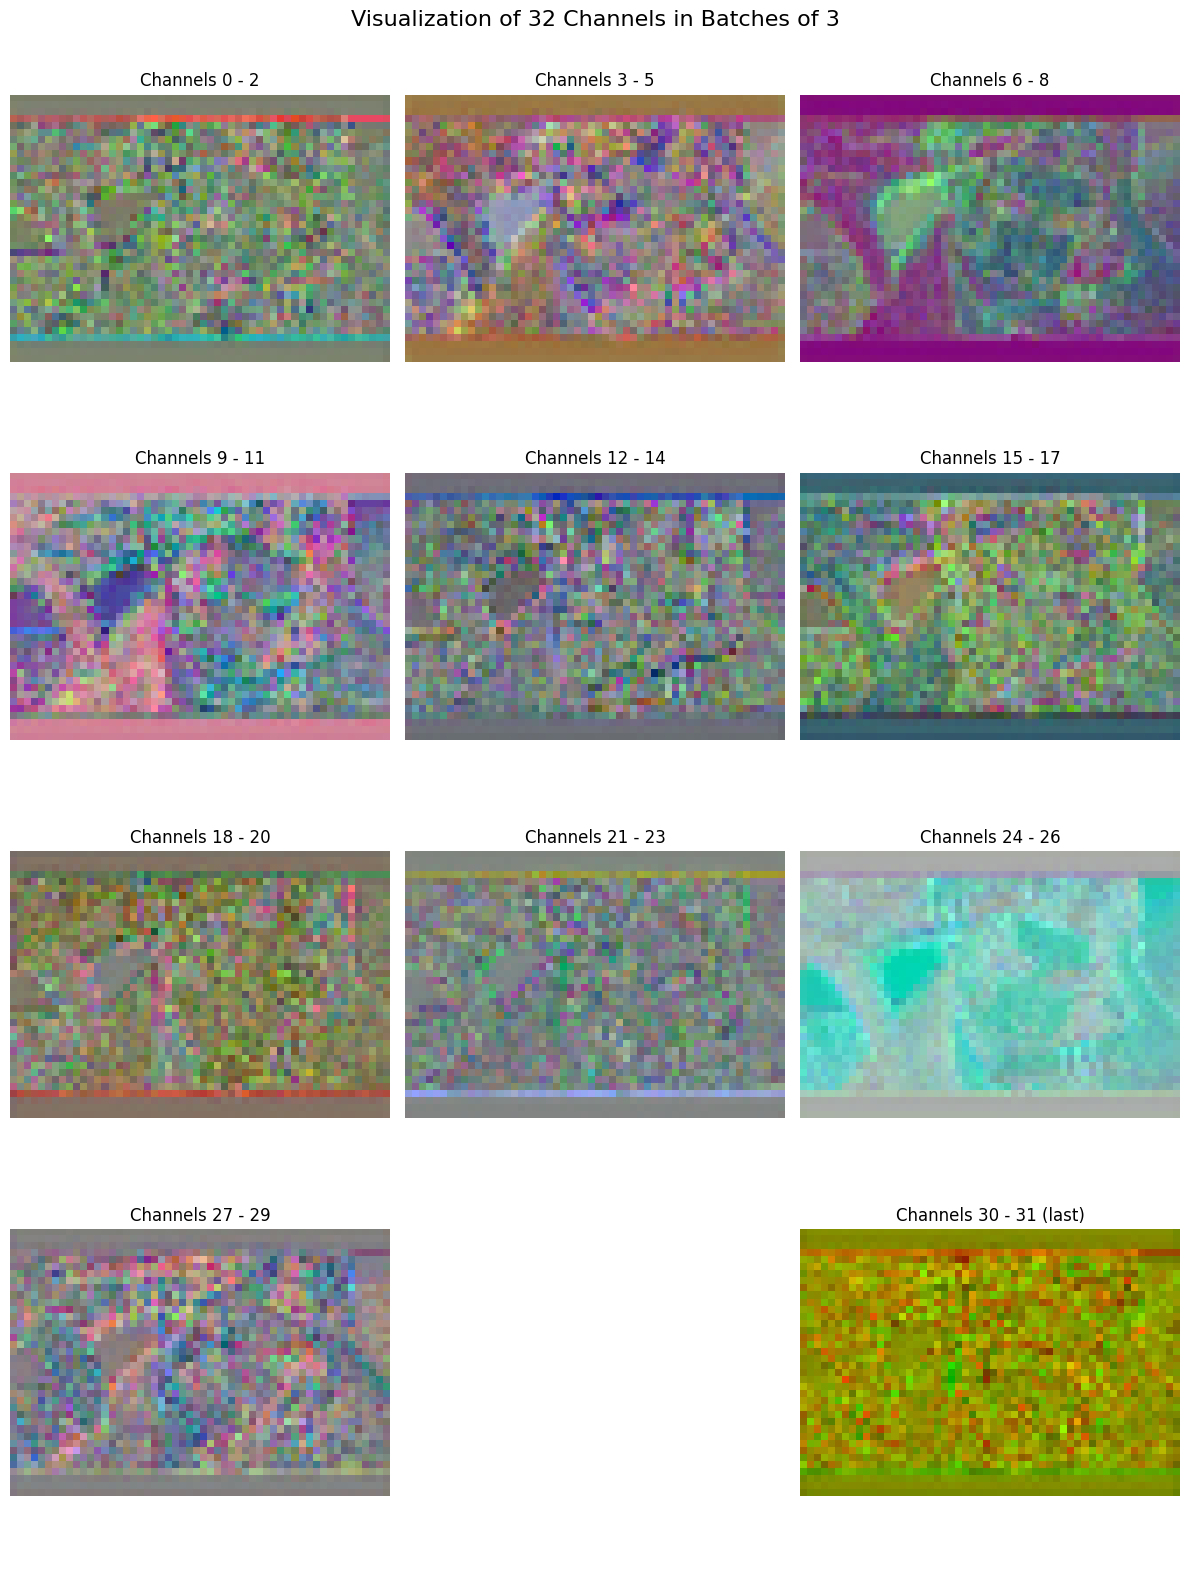

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Number of batches (each with 3 channels, except the last one)
num_batches = 11  # (10 batches of 3 + 1 batch of 2)

# Create figure
fig, axes = plt.subplots(4, 3, figsize=(12, 16))  # 4 rows, 3 columns
fig.suptitle("Visualization of 32 Channels in Batches of 3", fontsize=16)

# Loop through 10 full batches of 3 channels
for i in range(10):
    image = latents[i * 3 : (i + 1) * 3, :, :].numpy()

    # Normalize image data to [0, 1] range
    image_min = image.min()
    image_max = image.max()
    image = (image - image_min) / (image_max - image_min)

    # Transpose to (height, width, channels)
    image = image.transpose(1, 2, 0)

    # Plot in grid
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Channels {i*3} - {i*3+2}")

# Handle the last 2 channels
last_image = latents[30:32, :, :].numpy()

# Normalize
last_min = last_image.min()
last_max = last_image.max()
last_image = (last_image - last_min) / (last_max - last_min)

# Convert to 3-channel by adding a blank channel
last_image = np.concatenate((last_image, np.zeros((1, 38, 54))), axis=0)
last_image = last_image.transpose(1, 2, 0)

# Plot the last image
ax = axes[3, 2]  # Last subplot
ax.imshow(last_image)
ax.axis("off")
ax.set_title("Channels 30 - 31 (last)")

# Hide any unused subplots
for i in range(10, 11):  # We only use up to 11 slots
    axes[i // 3, i % 3].axis("off")

# Show the figure
plt.tight_layout()
plt.show()



d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


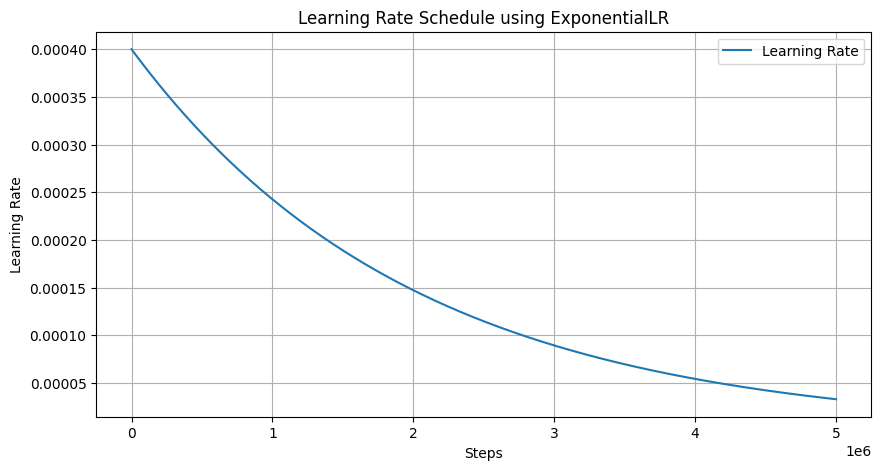

In [14]:
import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import ExponentialLR

# Simulated optimizer (SGD with initial LR)
optimizer = torch.optim.SGD([torch.tensor(1.0, requires_grad=True)], lr=0.0004)

# Define the scheduler with lambda function
lmbda = lambda epoch: 0.9999995  # Multiplicative decay factor
scheduler = ExponentialLR(optimizer, 0.9999995)

# Number of steps
num_steps = 5000000

# Store learning rates over time
lrs = []

for step in range(num_steps):
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step()

# Plot the learning rates over steps
plt.figure(figsize=(10, 5))
plt.plot(range(num_steps), lrs, label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule using ExponentialLR")
plt.legend()
plt.grid(True)
plt.show()
